# Nano ARPES and advanced data selection

`peaks` has several methods mainly designed for spatially-resolved nanoARPES/microARPES datasets, although many can be used in other circumstances where more advanced data selections (e.g. ROI analysis) is required

In [1]:
# Import packages
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import peaks as pks
import os

# Set default options
xr.set_options(cmap_sequential='Purples', keep_attrs=True)
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Example data
from peaks.core.utils.sample_data import ExampleData, plot_tutorial_example_figure

:::{tip}
nano-ARPES files can be large! It is useful to do what operations are possible to reduce the data (e.g. binning where possible). This has already been done in the tutorial data and so the data set here is rather compressed already, but in general, this can be helpful, and often it is useful to work with data loaded in a lazy fashion. It is also helpful to clear out old objects when no longer needed to avoid clogging the memory, including running the garbage checker, e.g.:

```python
SM1 = pks.load('some_map.nxs')
# ... various processing until SM1 is no longer required

del SM1  # Delete the old object

# Clear out the trash
import gc
gc.collect()
gc.collect()  # Run again to make sure we cleaned this up...
```
:::

## Focussing
An alingment (focussing) scan for nano-ARPES is essentially looking for increased sharpness as the beam is scanned across some feature on the sample. Several metrics for this are possible, which are shown by calling the :class:`peaks.core.display.plotting.plot_nanofocus` method, avaialble via the `.plot_nanofocus` accessor. The supplied data is recommended to be already integrated over the detector (e.g. as already naturally the case if running an `analyser_total` scan at Diamond I05.

In [2]:
# Load data (focussing scan)
defocus_scan = ExampleData.nano_focus()

i05-1-49292.nxs:   0%|          | 0.00/1.49M [00:00<?, ?B/s]

/Users/pdk6/miniconda3/envs/peaks-dev/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/pdk6/miniconda3/envs/peaks-dev/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


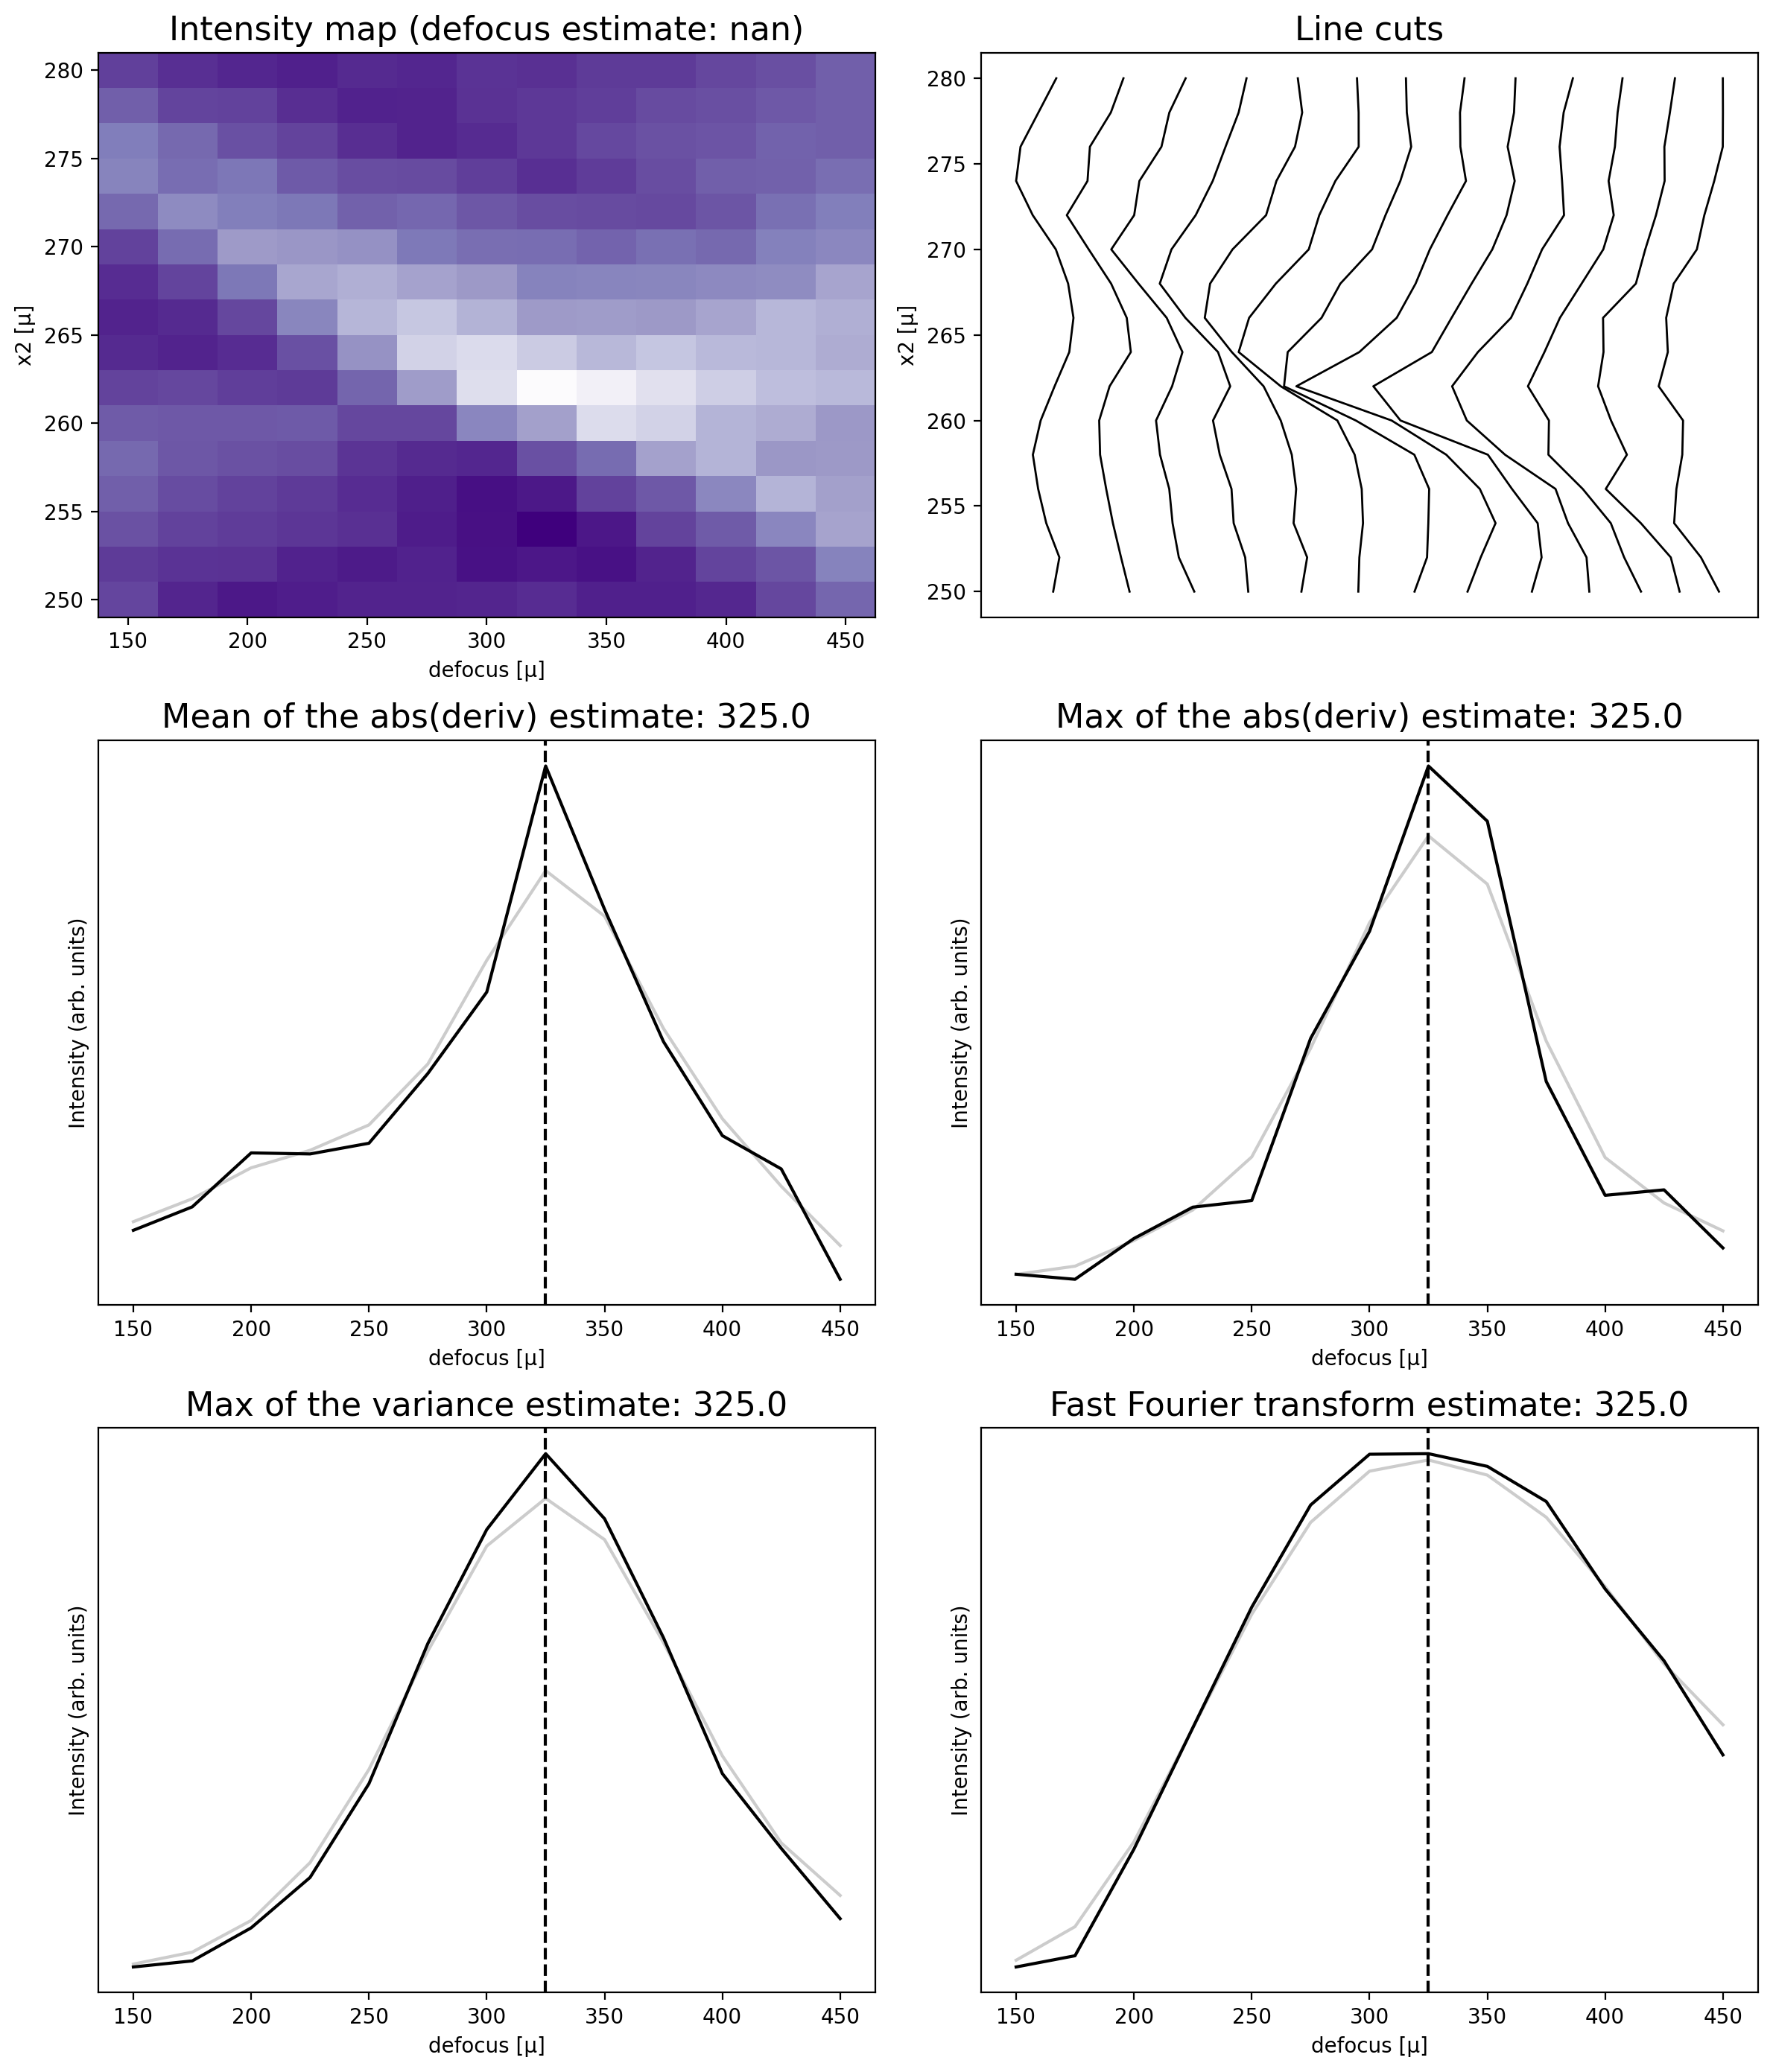

In [3]:
defocus_scan.plot_nanofocus()

## Spatial mapping data
See [getting started guide](./1_getting_started.ipynb#) for some examples of loading and doing grid plots of spatial mapping data, including on lazy loading of data

In [4]:
SM1 = ExampleData.SM().chunk()  # Convert to dask array to simulate loading larger data files

i05-1-24270_sm.nc:   0%|          | 0.00/86.7M [00:00<?, ?B/s]

We can integrate over the energy and angle axes to give a total intensity map, using the accessor `.tot()` method:

In [5]:
SM1_tot = SM1.tot()

As nanoARPES data is large, it is often loaded lazily, giving a :class:`dask` array. This can be computed by e.g. `.compute()` or by calling a function like `.plot()` that requires the computation

In [6]:
SM1_tot

<xarray.DataArray 'i05-1-24270' (x2: 31, x1: 14)> Size: 3kB
dask.array<chunksize=(31, 14), meta=pint.Quantity>
Coordinates:
  * x2       (x2) float64 248B 1.855e+03 1.856e+03 ... 1.884e+03 1.885e+03
  * x1       (x1) float64 112B -650.0 -649.0 -648.0 ... -639.0 -638.0 -637.0
Attributes: (8)

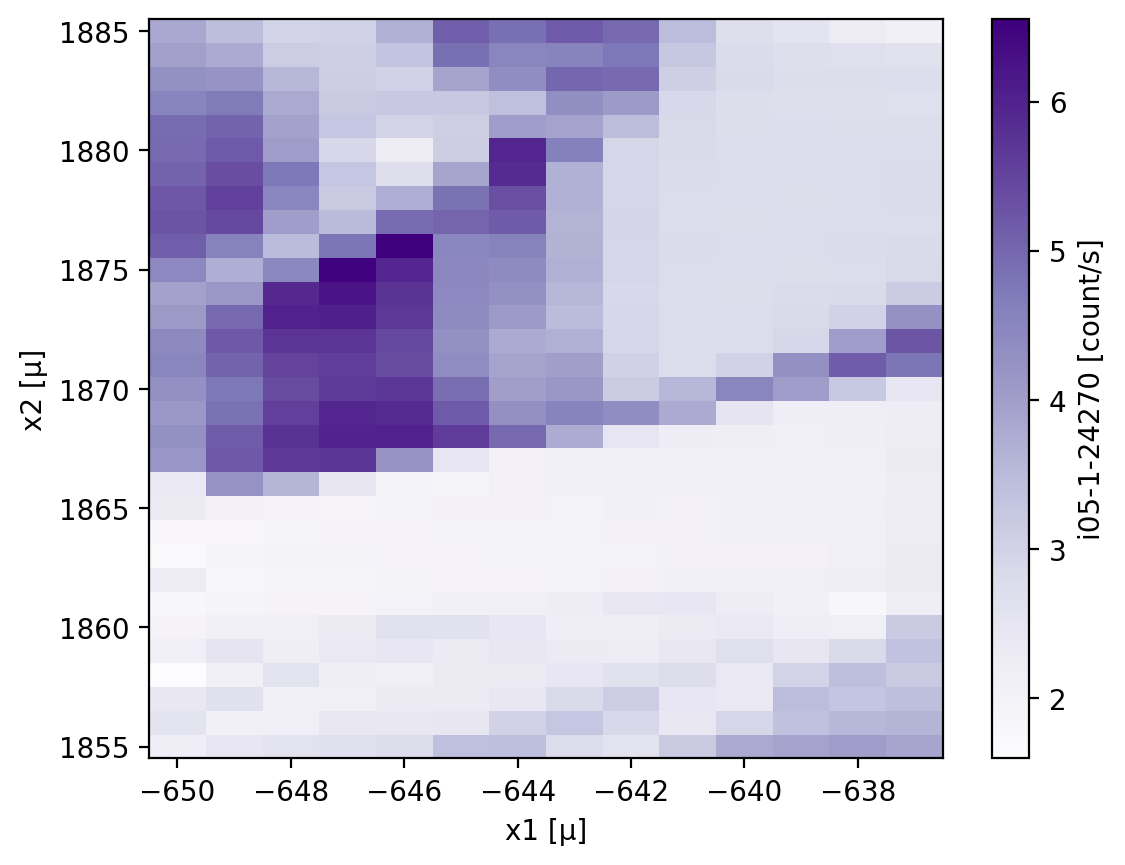

In [7]:
SM1_tot.plot()

We can integrate over the spatial directions to see the average dispersion by additionally passing the flag `spatial_int=True`:

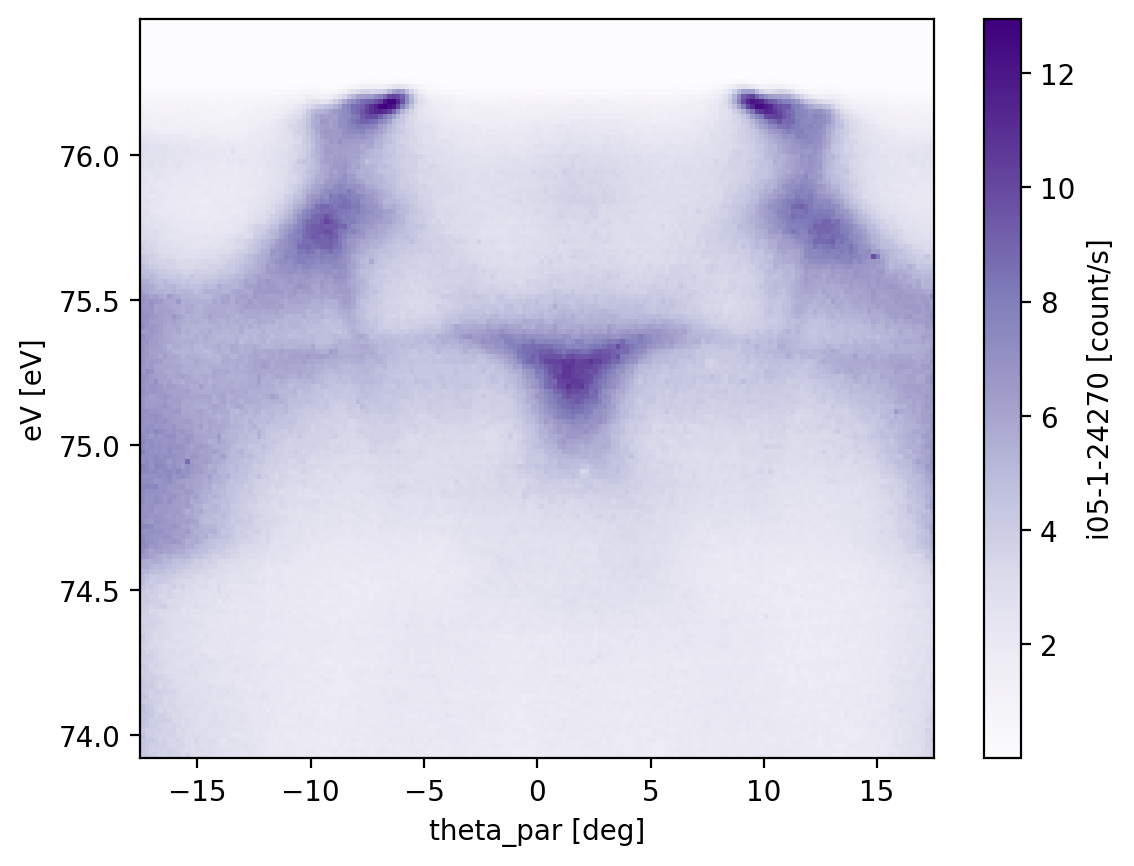

In [8]:
SM1_tot2 = SM1.tot(spatial_int=True)
SM1_tot2.plot()

:::{note}
Note, the above commands effectively load the data twice if it is loaded lazily in the first place. To speed up future computations, it is good practice to try and reduce the unnecessary data as much as possible and then `.persist()` the data if memory considerations allow. Ensure that the data will fit into memory before calling this!
:::

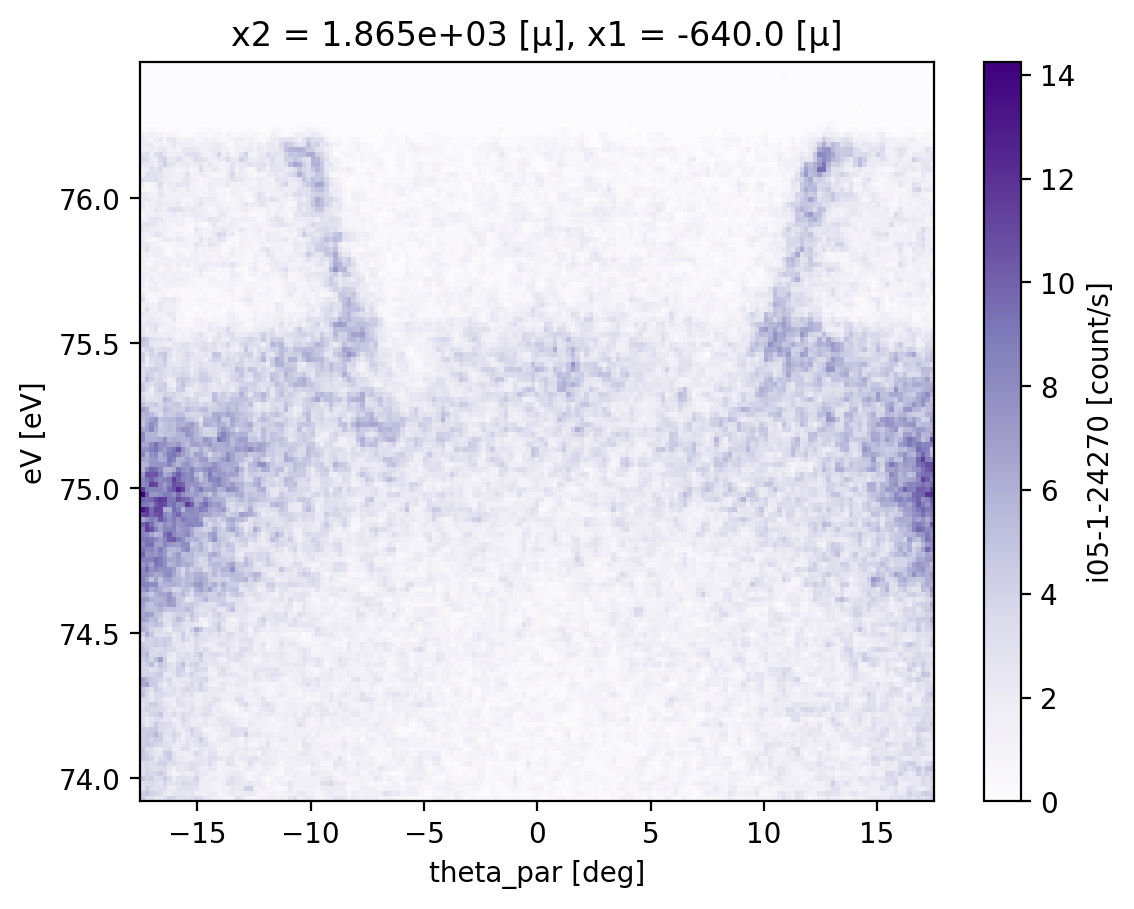

In [9]:
# Inspect the data to check needed ranges
SM1.isel(x1=10,x2=10).plot()

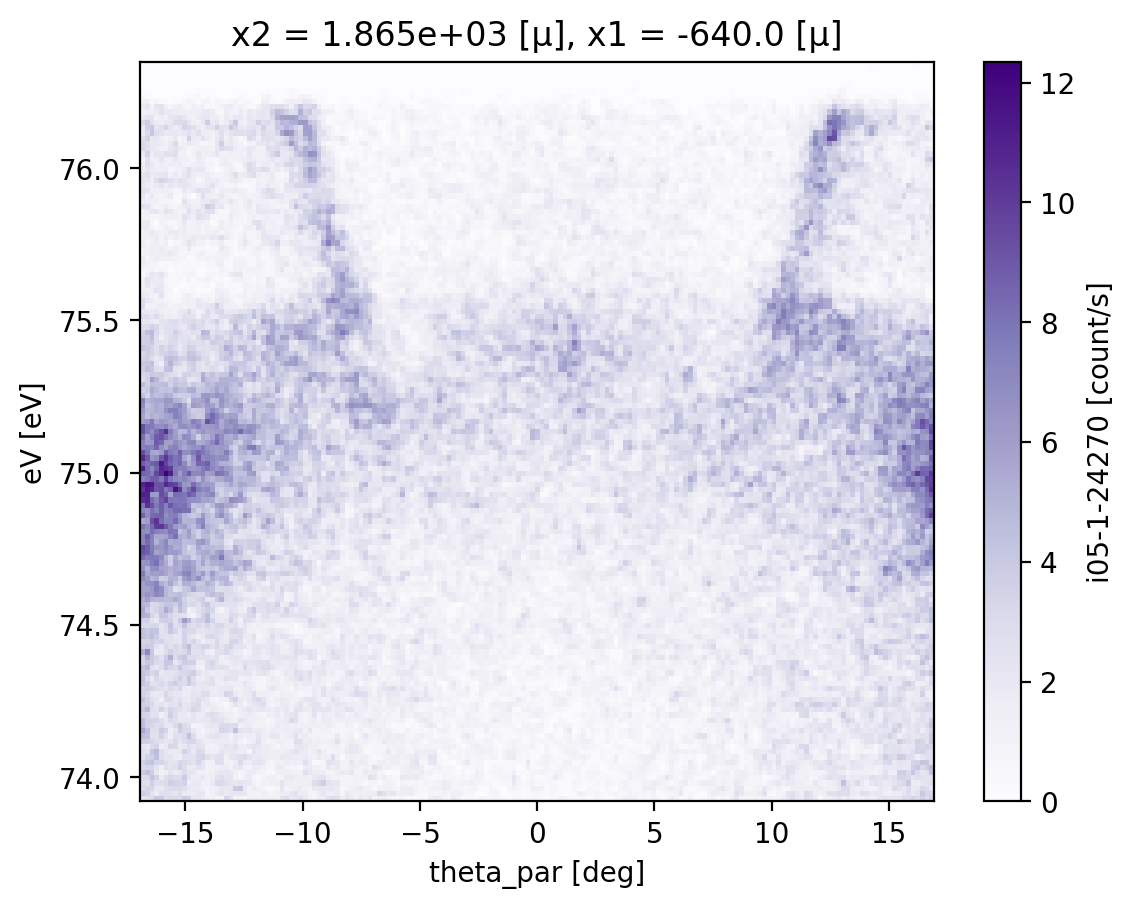

In [10]:
SM1.isel(x1=10,x2=10).sel(theta_par=slice(-17,17),eV=slice(73.9,76.35)).plot()

In [11]:
SM1_p = (
    SM1.sel(theta_par=slice(-17,17),eV=slice(73.9,76.35))  # Select the data to minimal required range
    .bin_data(eV=2,theta_par=2)  # Bind the data 2x2 in eV and theta_par
    .persist()  # Persist to memory - note do the persist following the above data reduction
)

## Masking

Often in nano-ARPES, we will want to bin over a region of interest in the data, either in E and angle to make a  spatial map based on some feature of interest in the dispersion, or over x1 and x2 in order to generate a dispersion based on the spatial average over a portion of the map.

The function :class:`peaks.core.process.data_select.mask_data` applies a polygon region of interest (ROI) as a mask to such multidimensional data. By default, the function will then extract the mean over the two dimensions defined by the ROI. For a rectangular ROI, this is equivalent to a simple .sel over those dimensions followed by a mean, but an arbitrary polygon can be used to define the ROI, and analysis history metadata is added.

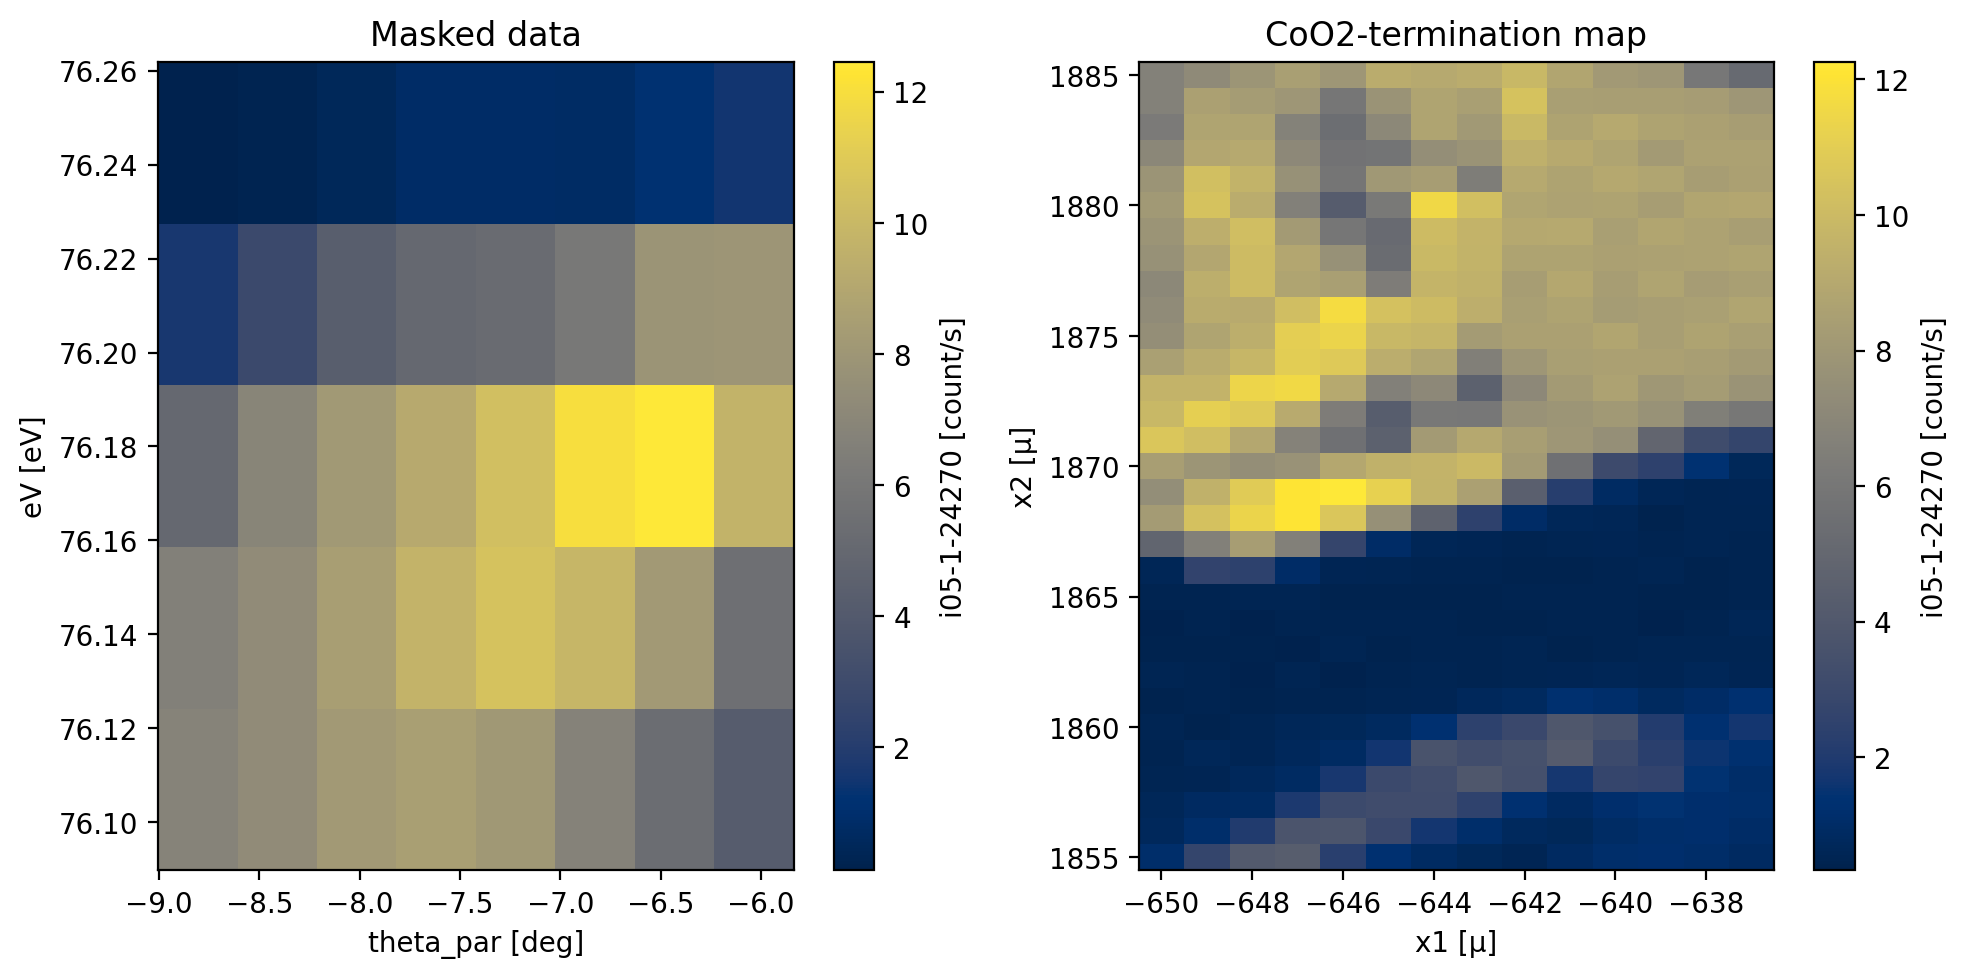

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(10,5))

#Select a region that covers one of the sets of surface states in the mean dispersion, now with a non-rectangualar mask
#Define an ROI as a dictionary
ROI1 = {'eV': [76.1,76.2,76.25,76.25,76.1], 'theta_par': [-9.1,-9.5,-9,-4,-6]}

#Return with return_masked=True to get the full masked data back
masked = SM1_p.mask_data(ROI1,return_integrated=False)
masked.mean(['x1','x2']).plot(y='eV', ax=axes[0], cmap='cividis')
axes[0].set_title('Masked data')

#Call without return_masked (or return_masked=False) to integrate over this ROI and return the relevant map
ROI_map = SM1_p.mask_data(ROI1)
ROI_map.plot(ax=axes[1], cmap='cividis')
axes[1].set_title('CoO2-termination map')

plt.tight_layout()

### ROI_plot

The ROIs can be plotted atop the data using the `pks.plot_ROI()` method:

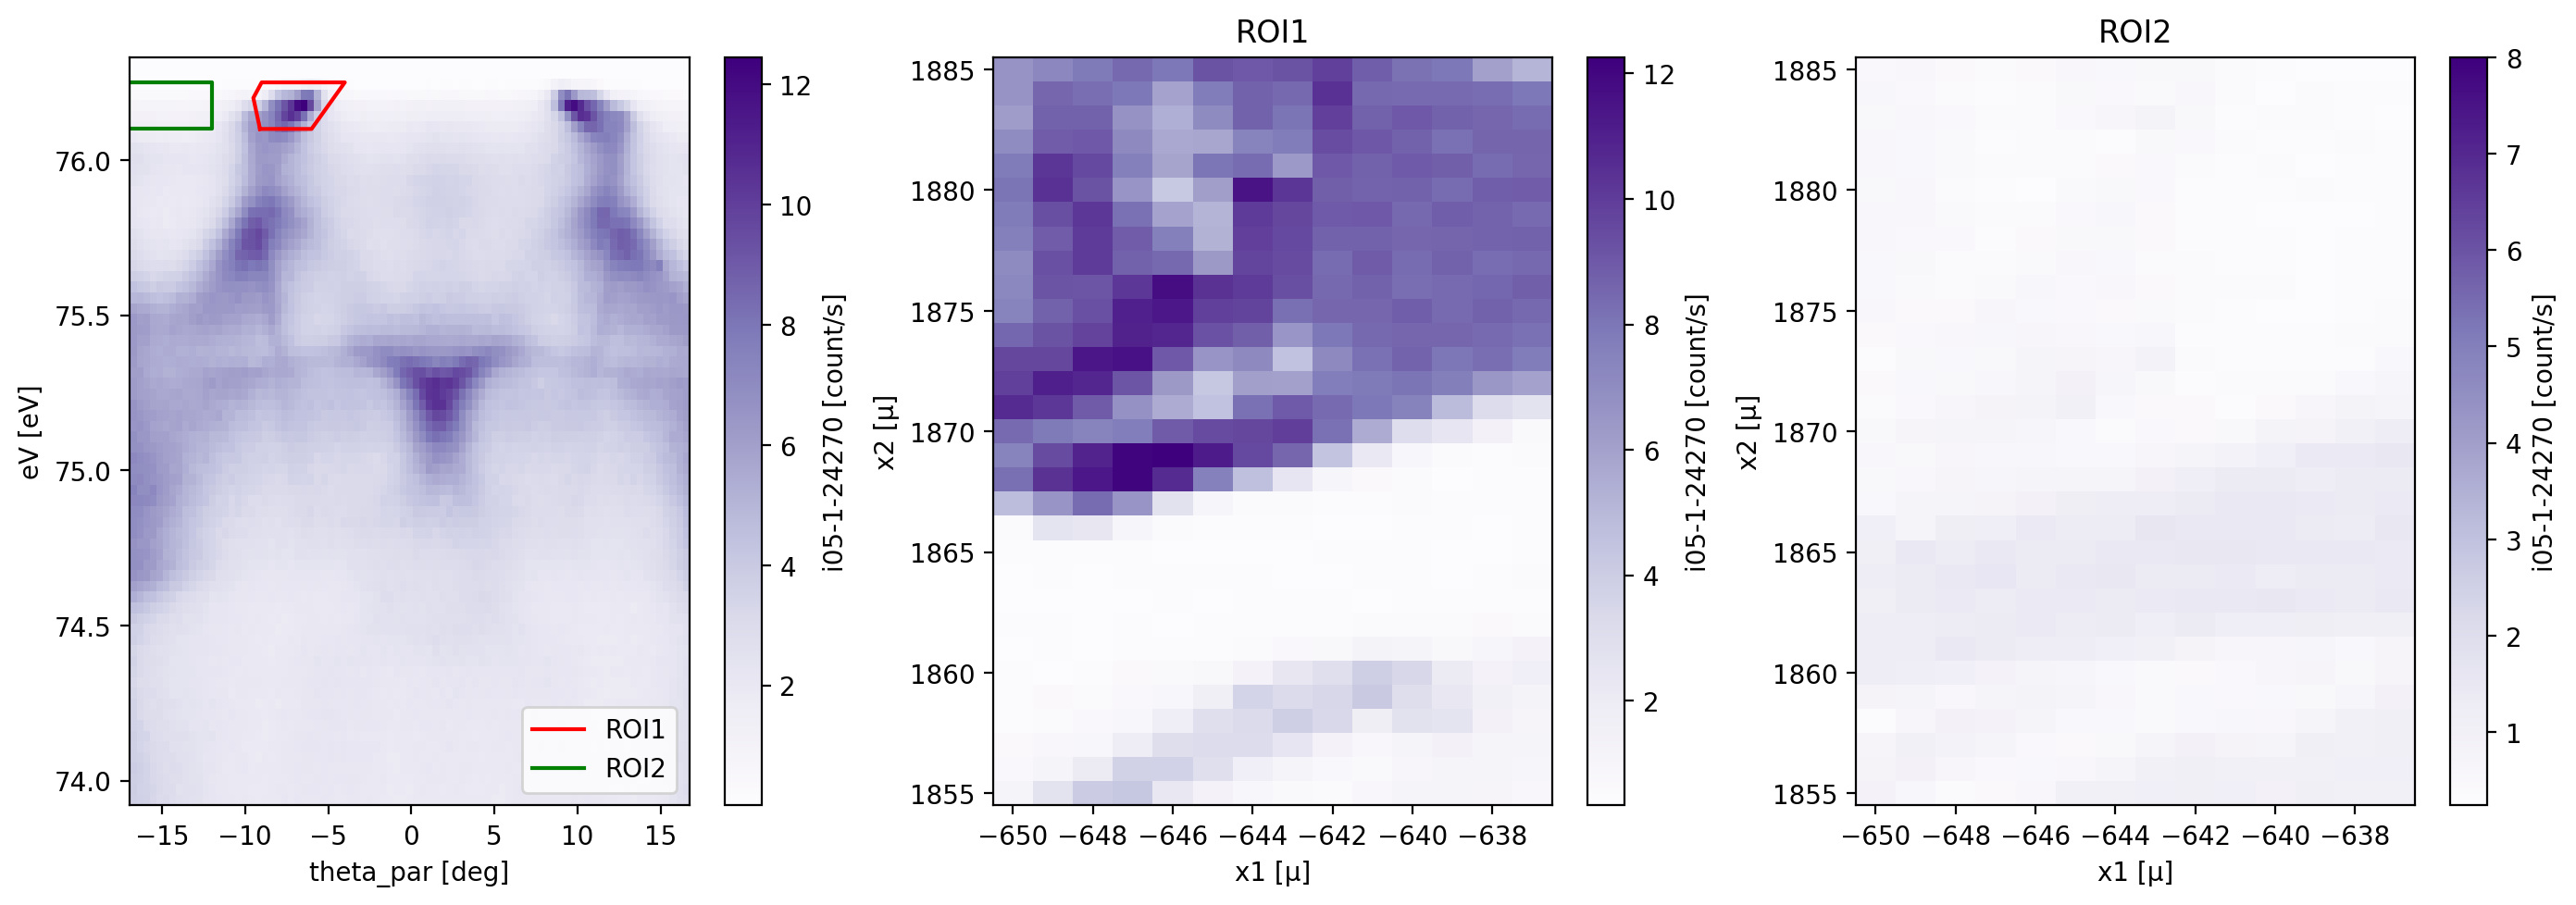

In [13]:
#First, let's define a second ROI
ROI2 = {'eV': [76.1,76.25,76.25,76.1], 'theta_par': [-17,-17,-12,-12]}

fig, axes = plt.subplots(ncols=3, figsize=(14,5))
SM1_p.tot(spatial_int=True).plot(y='eV', ax=axes[0])
pks.plot_ROI(ROI1, y='eV', color='r', label='ROI1', ax=axes[0])
pks.plot_ROI(ROI2, y='eV', color='g', label='ROI2', ax=axes[0],loc='lower right')

#Plot the corresponding spatial maps
ROI_map.plot(ax=axes[1]) #ROI1 region from above
axes[1].set_title('ROI1')

ROI_map2 = SM1_p.mask_data(ROI2)
ROI_map2.plot(ax=axes[2],vmax=8)
axes[2].set_title('ROI2')

plt.tight_layout()

Look at the difference plot of these two spatial maps to give an idea of the different teminations and features

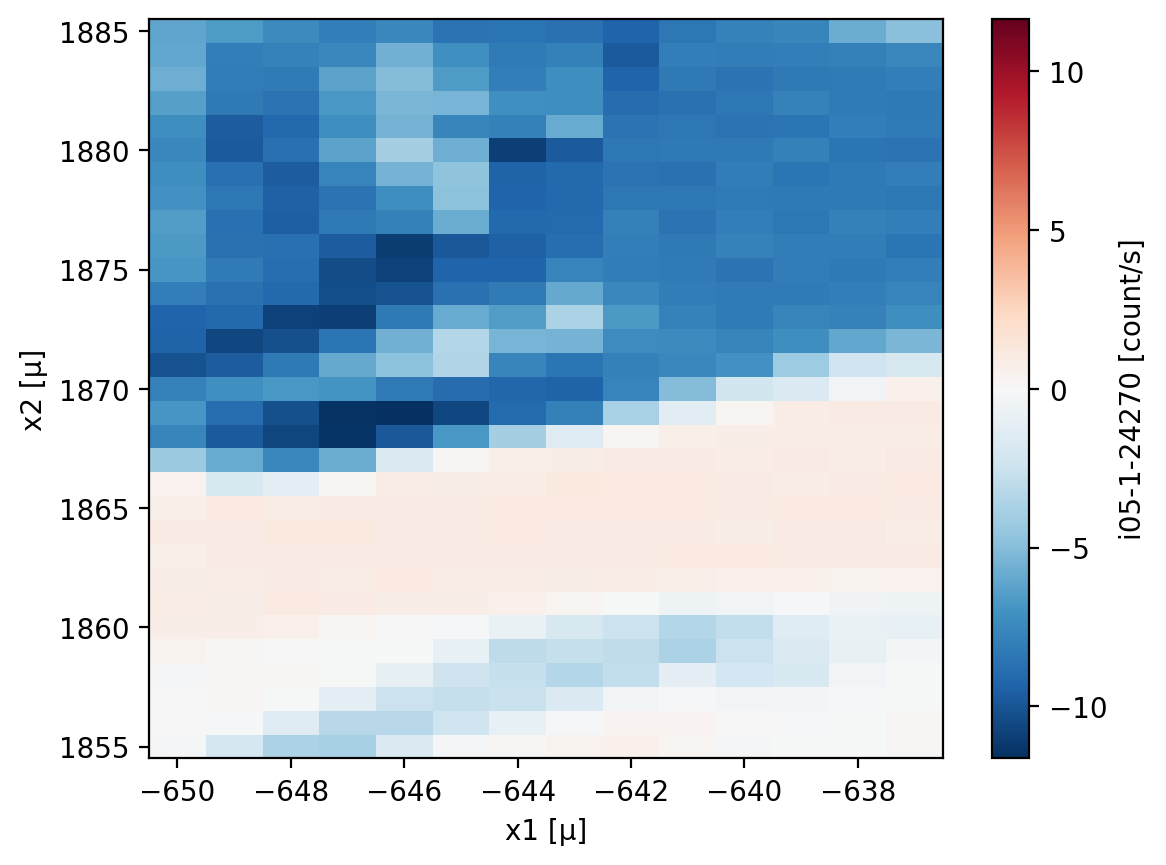

In [14]:
diff_map = ROI_map2 - ROI_map
diff_map.plot()

We can also call the ROI functions on different axes. E.g. to extract ROI from the spatial dimensions:

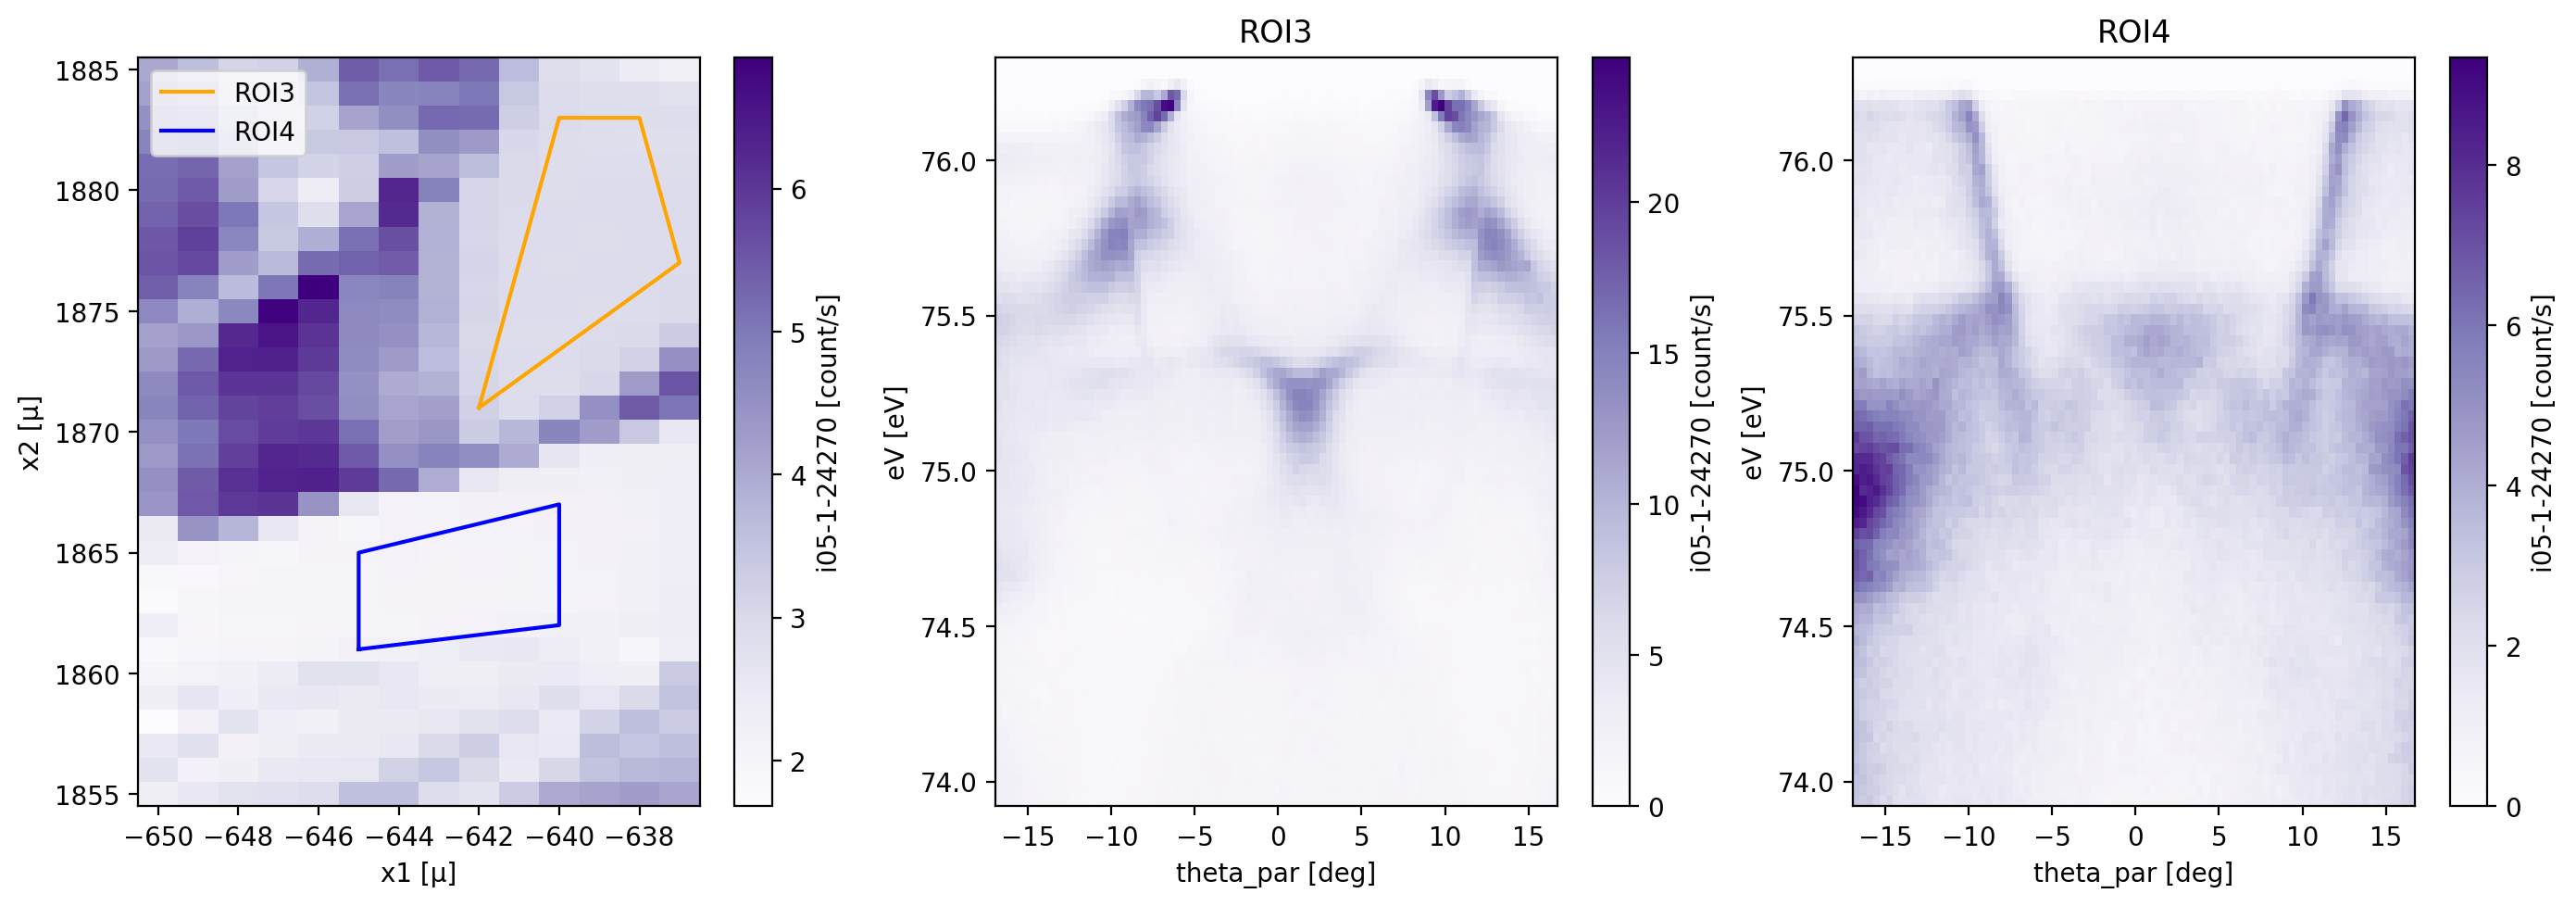

In [15]:
fig, axes = plt.subplots(ncols=3, figsize=(14,5))

SM1_p.tot().plot(ax=axes[0])

#Define and plot the ROIs
ROI3 = {'x1': [-642,-640,-638,-637], 'x2': [1871,1883,1883,1877]}
pks.plot_ROI(ROI3, y='x2', color='orange', label='ROI3', ax=axes[0])
ROI4 = {'x1': [-645,-645,-640,-640], 'x2': [1861,1865,1867,1862]}
pks.plot_ROI(ROI4, y='x2', color='blue', label='ROI4', ax=axes[0])

ROI_disp3 = SM1_p.mask_data(ROI3)
ROI_disp3.plot(ax=axes[1],y='eV')
axes[1].set_title('ROI3')
ROI_disp4 = SM1_p.mask_data(ROI4)
ROI_disp4.plot(ax=axes[2],y='eV')
axes[2].set_title('ROI4')

plt.tight_layout()

## Interactive spatial map explorer
One of the interactive UIs is designed to work with 4D data. Call with the general `.disp()` function, and the relevant UI is loaded given the data loaded in. On tab two, you can select ROIs grapically, and save them to a list in the UI using the buttons shown. If you click `Copy ROI Store`, these ROIs are copied to the clipboard in a form that can be directly added to the attributes of the data.

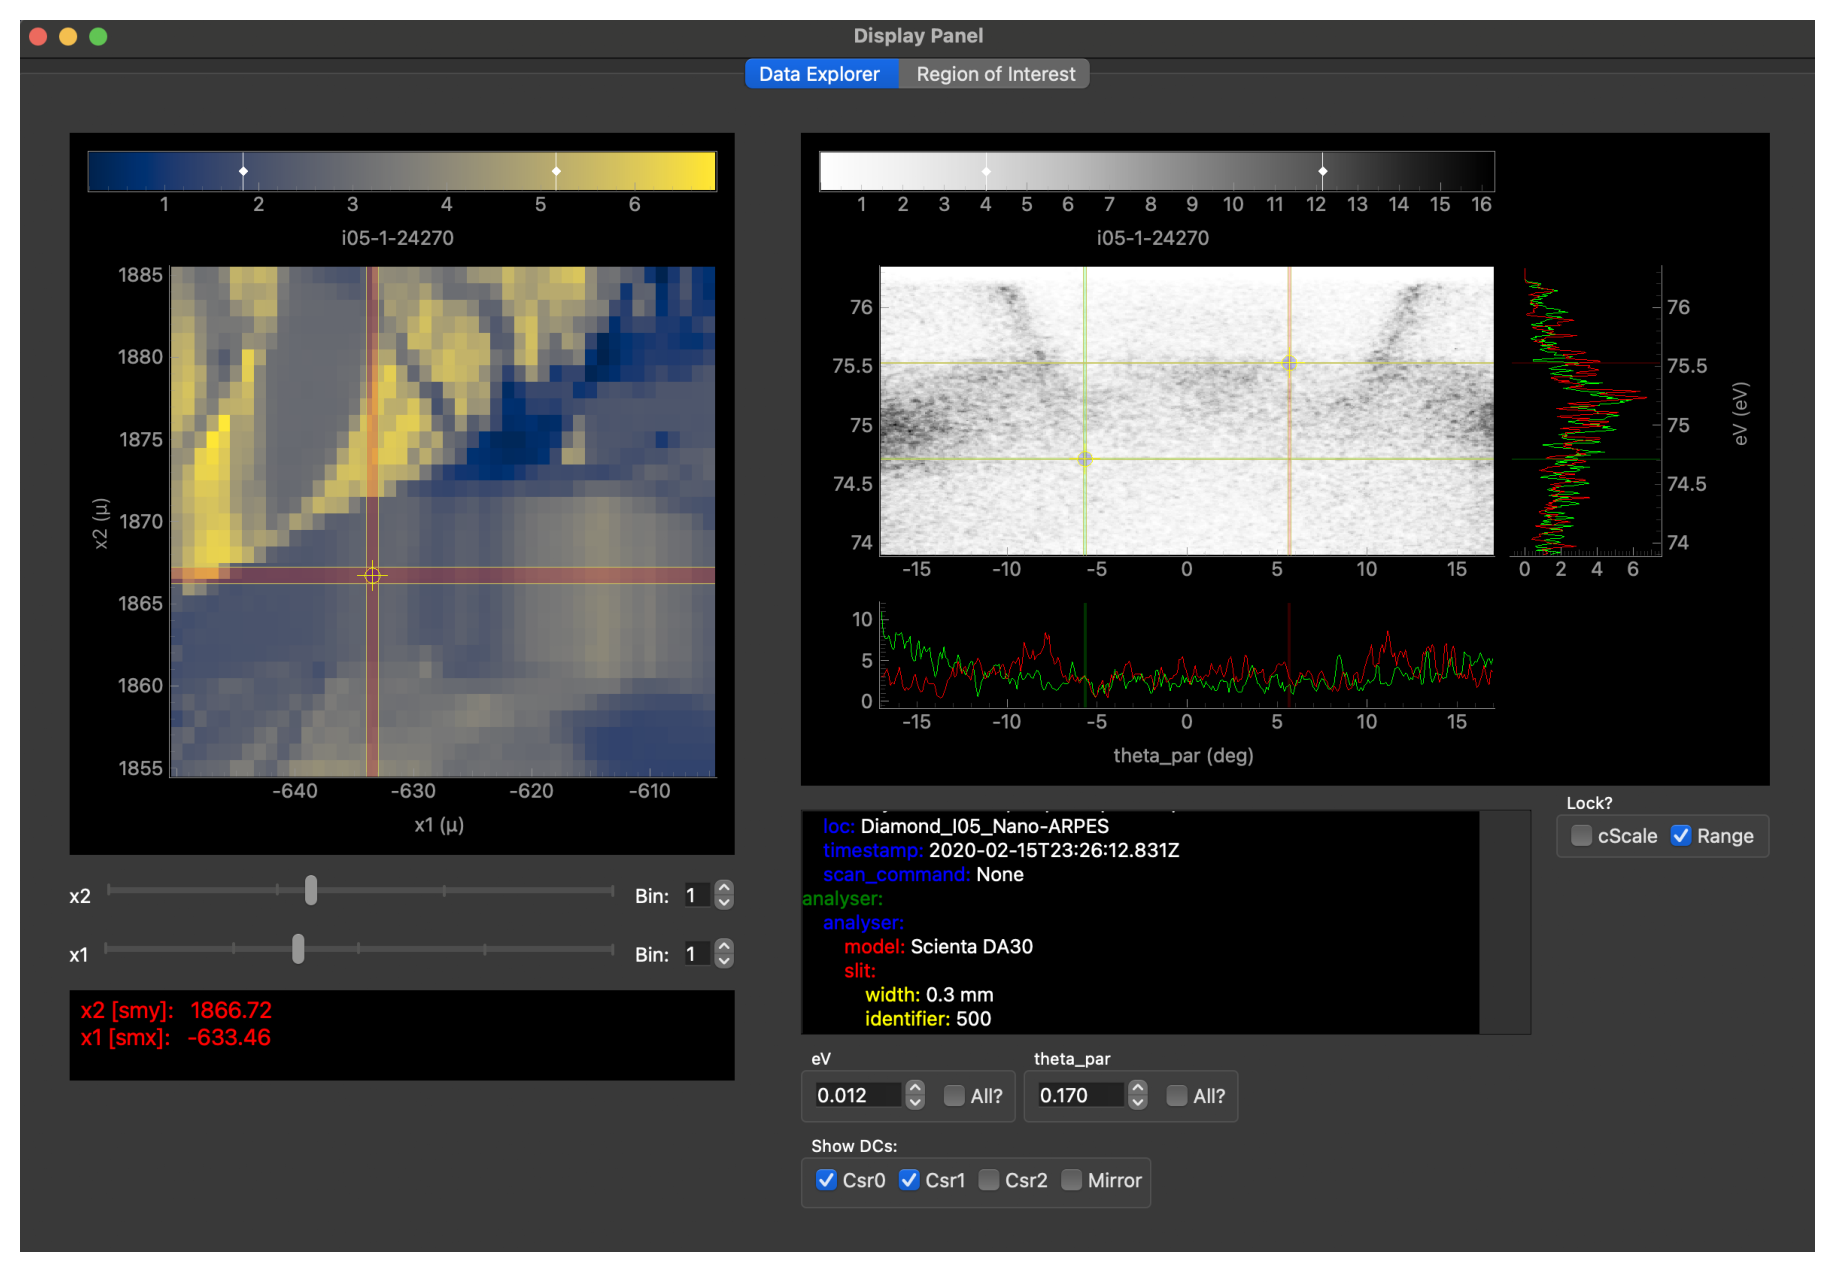

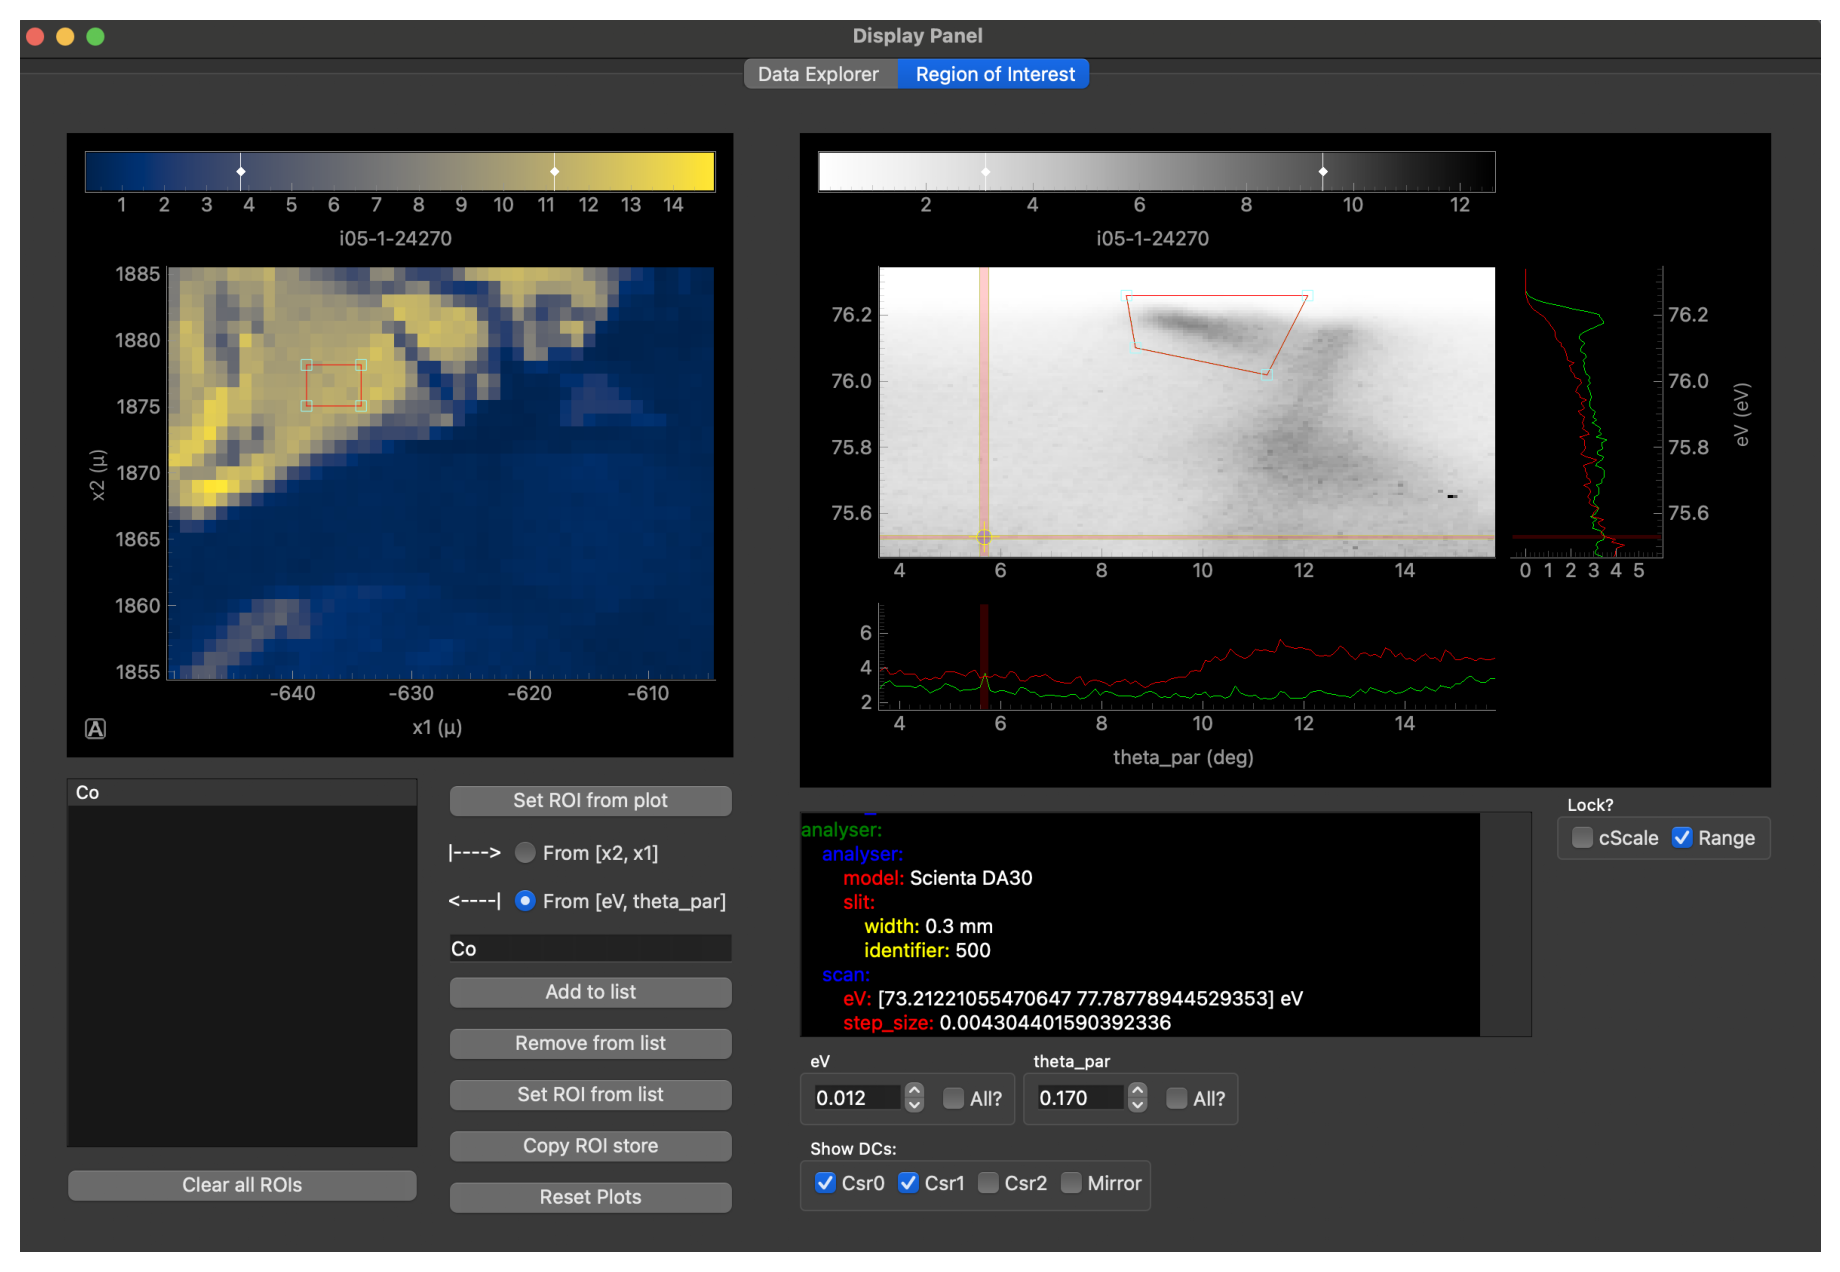

In [16]:
plot_tutorial_example_figure("4D_disp_ex1.png")
plot_tutorial_example_figure("4D_disp_ex2.png")

:::{tip}
If the data fits in memory, it is recommend to `.persist()` or `.compute()` the data before passing to the display panel. Computed data will be slightly quicker for the initial data explorer tab, while persisted data can be slightly quicker for the ROI tab. Both will be significantly quicker than using lazy data. However, if the data does not fit in memory, it should be possible in princple to still use the disp panel without either persisting or computing.
:::

## Diamond I05-nano additional options
### Slant correction
At I05-nano, at least during the beamtimes in 2021 and 2022, the Scienta DA30 has a weird slant on the detector. This can be removed during loading by calling the loader with the custom option `slant_correct=True`, and optionally providing a factor (`slant_factor=`). If no `slant_factor` is provided, the default value of 8/PE deg/eV is used.Alternatively, the accessor `.slant_correct` can be used to apply this to already loaded data.

In [17]:
disp_orig = ExampleData.dispersion4()

i05-1-31473.nxs:   0%|          | 0.00/3.61M [00:00<?, ?B/s]

In [18]:
disp_sl_corr = disp_orig.slant_correct()

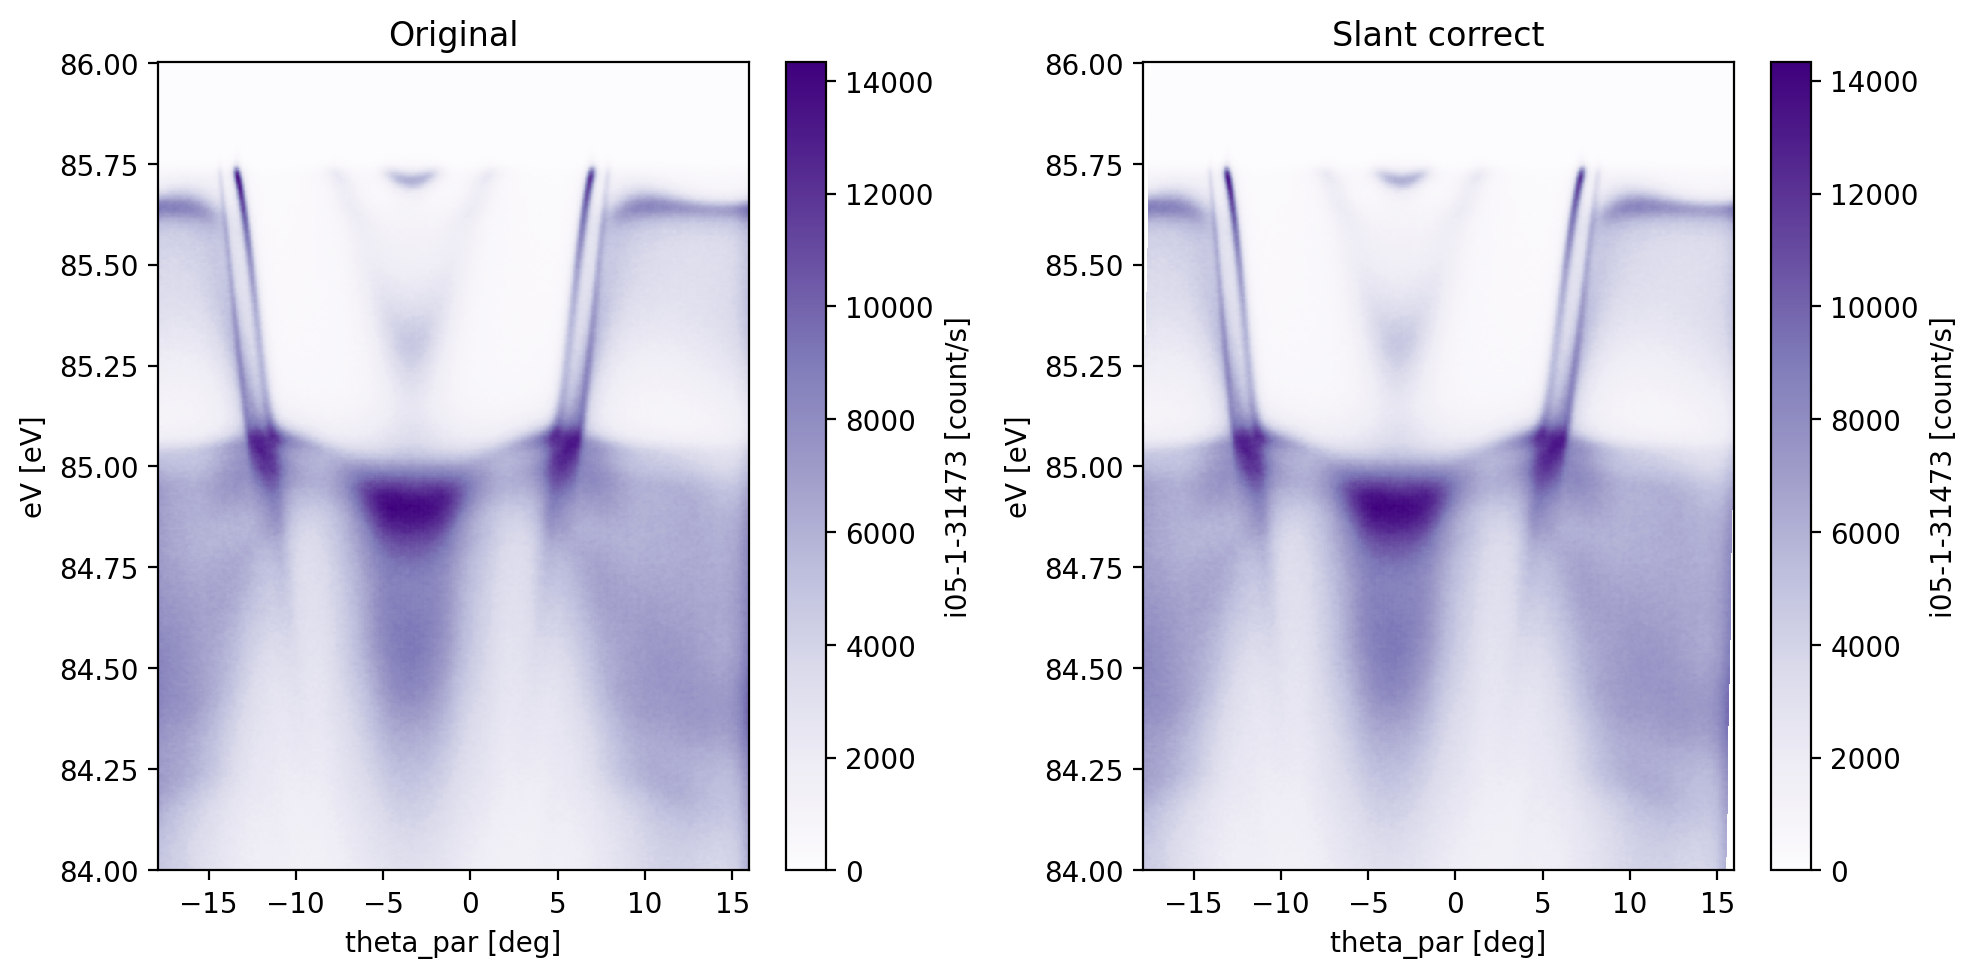

In [19]:
pks.plot_grid([disp_orig, disp_sl_corr], titles=['Original', 'Slant correct'])

### Normalisation by $I_0$
It can be desirable to normlise the measured count rate by some measure of the beam current. For Diamond I05 Nano, the loader supports this option for more recent scans where the relevant metadata is recorded throughout the scan. The normalisation can be performed only on data loading, by passing the `norm_by_I0=True` key:

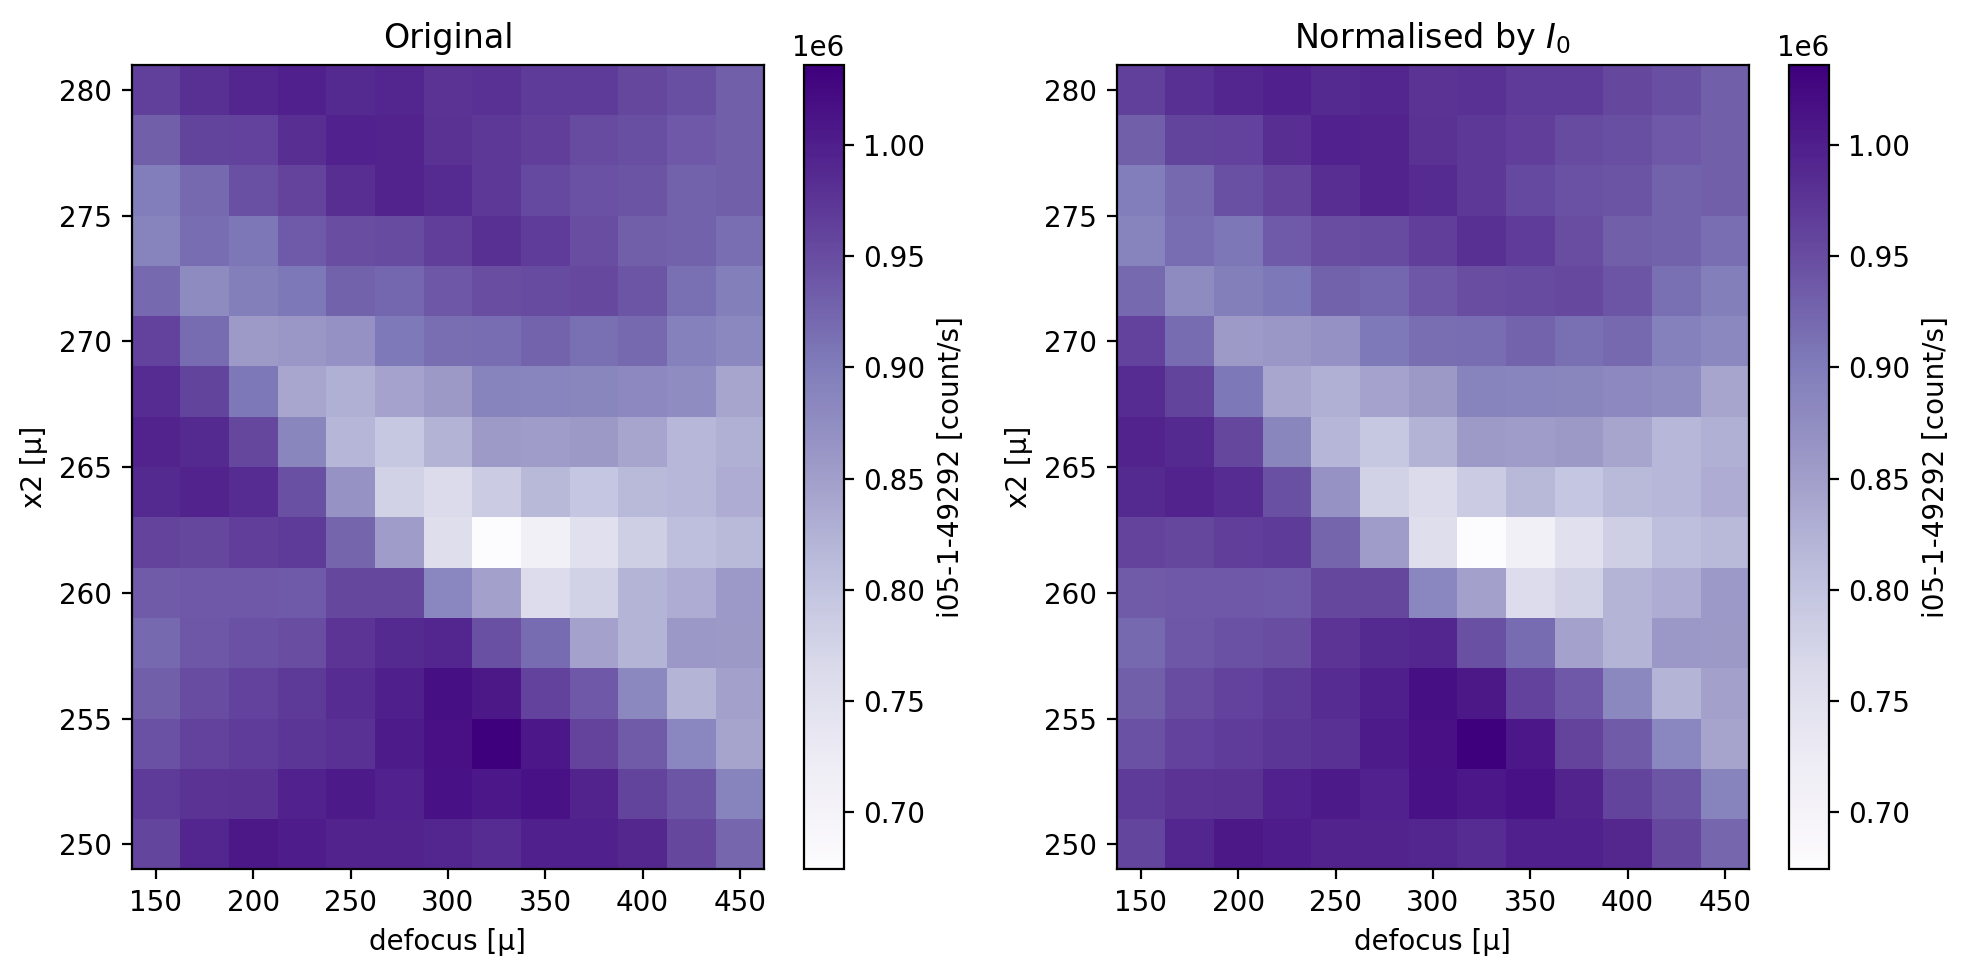

In [20]:
scan = ExampleData.nano_focus()  # Default is not to normalise by I_0 on load
scan_norm = ExampleData.nano_focus_w_I0norm()  # This data was loaded with norm_by_I0=True passed in loader

# Plot the data
pks.plot_grid([scan,scan_norm], titles=["Original", "Normalised by $I_0$"])